In [1]:
# Standard Libraries
import os
import sys
import time

# 3rd Party Libraries
import pandas as pd
import cmath
import matplotlib.pyplot as plt
import networkx as nx

# local libraries
from WEC_GRID.utilities.util import read_paths
from WEC_GRID.viz.psse_viz import PSSEVisualizer

# Initialize the PATHS dictionary
PATHS = read_paths()
CURR_DIR = os.path.dirname(os.path.abspath("./"))

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
psse_path = PATHS["psse"]
sys.path.extend(
    [
        os.path.join(psse_path, subdir)
        for subdir in ["PSSPY37", "PSSBIN", "PSSLIB", "EXAMPLE"]
    ]
)
os.environ["PATH"] = (
    os.path.join(psse_path, "PSSPY37")
    + ";"
    + os.path.join(psse_path, "PSSBIN")
    + ";"
    + os.path.join(psse_path, "EXAMPLE")
    + ";"
    + os.environ["PATH"]
)

import psse35

psse35.set_minor(3)
import psspy

psspy.psseinit(50)

case_file = "../models/grid_models/this_ieee14.raw"
psspy.read(1, case_file)
psspy.fnsl()

    Sets PSSE environment to latest minor version among installed versions of PSSE 35.
    Use psse35.set_minor(n) to set PSSE35 minor version (n) to use.
        Example, for PSSE 35.0.x, use this as: psse35.set_minor(0)

 Input error detected at !
 -m ipykernel_launcher --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 "--Session.signature_scheme=\"hmac-sha256\"" "--Session.key=b\"43c64bb3-3c0a-4624-b4d7-57c1cf4e282f\"" --shell=9012 "--transport=\"tcp\"" --iopu
                                                                                                          !

 PSS(R)E Xplore Version 35
 Copyright (c) 1976-2024
 Siemens Industry, Inc.,
 Power Technologies International                            (PTI)
 This program is a confidential  unpublished  work  created  and  first
 licensed in 1976.  It is a trade secret which is the property of  PTI.
 All use,  disclosure,  and/or reproduction not specifically authorized
 by  PTI  is prohibited.   This  program is protected  under

0

In [2]:
def visualize_contingency(network_edges, df, index, positions):
    """
    Visualize the power network and highlight the contingency lines, and display detailed convergence status and outaged lines.

    :param network_edges: List of edges (lines) in the network.
    :param df: DataFrame containing contingency results.
    :param index: Index of the row in the DataFrame to visualize.
    :param positions: Fixed positions of the nodes.
    """
    # Retrieve contingency result from DataFrame
    line1 = tuple(df.loc[index, "Line 1"])
    line2 = tuple(df.loc[index, "Line 2"])
    result = df.loc[index, "Result"]
    iterations = df.loc[index, "Iterations"]

    # Map of result codes to messages
    result_messages = {
        0: "Met convergence tolerance",
        1: "Iteration limit exceeded",
        2: "Blown up",
        3: "Terminated by non-divergent option",
        4: "Terminated by console interrupt",
        5: "Singular Jacobian matrix or voltage of 0.0 detected",
        6: "Inertial power flow dispatch error",
        7: "OPF solution met convergence tolerance",
        9: "Solution not attempted",
        10: "RSOL converged with Phase shift locked",
        11: "RSOL converged with TOLN increased",
        12: "RSOL converged with Y load conversion due to low voltage",
    }

    G = nx.Graph()
    G.add_edges_from(network_edges)

    # Define colors for edges
    edge_colors = [
        "red"
        if (
            edge == line1 or edge == line2 or edge == line1[::-1] or edge == line2[::-1]
        )
        else "black"
        for edge in G.edges
    ]

    # Draw the network with fixed positions
    nx.draw(
        G,
        positions,
        with_labels=True,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=500,
        font_size=8,
    )

    # Annotate with detailed convergence status, iteration count, and outaged lines
    status_message = result_messages.get(result, "Unknown status")
    outage_info = f"Outaged Lines: {line1} and {line2}"
    plt.text(
        0.05,
        0.95,
        f"{outage_info}\nStatus: {result} ({status_message})\nIterations: {iterations}",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.5),
        fontsize=10,
    )

    plt.show()

In [9]:
# Retrieve all lines in the system
ierr, (fromnumber, tonumber) = psspy.abrnint(
    -1, 1, 1, string=["FROMNUMBER", "TONUMBER"]
)
# Create the network graph and calculate fixed positions
network_edges = [(fromnumber[i], tonumber[i]) for i in range(len(fromnumber))]
G = nx.Graph()
G.add_edges_from(network_edges)
fixed_positions = nx.spring_layout(G)  # Calculate positions


# Define new columns for the DataFrame
columns = ["Line 1", "Line 2", "Result", "Iterations"]
contingency_df = pd.DataFrame(columns=columns)

ierr, (fromnumber, tonumber) = psspy.abrnint(
    -1, 1, 1, string=["FROMNUMBER", "TONUMBER"]
)

# Create a list of unique line identifiers (each a tuple of 'from' and 'to' bus numbers)
unique_lines = list(zip(fromnumber, tonumber))

# Loop through all pairs of unique lines
for i in range(len(unique_lines)):
    for j in range(i + 1, len(unique_lines)):
        line1 = unique_lines[i]
        line2 = unique_lines[j]

        if line1 != line2:
            # Outage both lines simultaneously
            IERR = psspy.branch_chng(line1[0], line1[1], "1", 0)  # turn off line 1
            IERR = psspy.branch_chng(line2[0], line2[1], "1", 0)

            # Run power flow for the combined outage
            ierr = psspy.fnsl()  #

            # Check the power flow results
            result = psspy.solved()
            itr = psspy.iterat()

            # Append the results to the DataFrame
            contingency_df = contingency_df.append(
                {"Line 1": line1, "Line 2": line2, "Result": result, "Iterations": itr},
                ignore_index=True,
            )

            # Restore the lines to their original state
            psspy.branch_chng(*line1, "1", 1)
            psspy.branch_chng(*line2, "1", 1)
            ierr = psspy.fnsl()

# Now, contingency_df contains your contingency analysis results


 Power flow data changed for non-transformer branch circuit "1" from 1 [1           1.0000] to 2 [2           1.0000]:
 X----------------ORIGINAL----------------X  X---------------NEW VALUE----------------X  DATA ITEM
                        1                                           0                    ST

 Power flow data changed for non-transformer branch circuit "1" from 1 [1           1.0000] to 39 [39          1.0000]:
 X----------------ORIGINAL----------------X  X---------------NEW VALUE----------------X  DATA ITEM
                        1                                           0                    ST

 ERROR: 0 in-service branches connected to type 1 bus 1 [1           1.0000]

 Messages for api FNSL
 Topology error: 1 bus(es) with bus type code and series element status inconsistencies   (001815)

 Power flow data changed for non-transformer branch circuit "1" from 1 [1           1.0000] to 2 [2           1.0000]:
 X----------------ORIGINAL----------------X  X----------

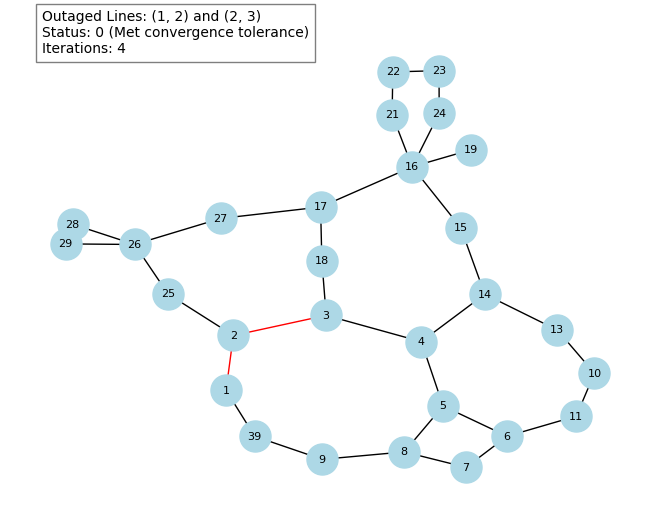

In [11]:
# BUS 30 is the slack bus

# Filter the DataFrame
filtered_contingencies = contingency_df[contingency_df["Result"] == 0]

# Reset the index of the filtered DataFrame
filtered_contingencies.reset_index(drop=True, inplace=True)

# Now you can visualize the contingency at the new index
visualize_contingency(network_edges, filtered_contingencies, 0, fixed_positions)

In [10]:
contingency_df

,Line 1,Line 2,Result,Iterations
0,"(1, 2)","(1, 39)",9,3
1,"(1, 2)","(2, 3)",0,4
2,"(1, 2)","(2, 25)",0,3
3,"(1, 2)","(3, 4)",0,3
4,"(1, 2)","(3, 18)",0,2
...,...,...,...,...
556,"(26, 27)","(26, 29)",5,1
557,"(26, 27)","(28, 29)",5,1
558,"(26, 28)","(26, 29)",9,1
559,"(26, 28)","(28, 29)",9,1


In [6]:
filtered_contingencies

,Line 1,Line 2,Result,Iterations
0,"(1, 2)","(2, 3)",0,4
1,"(1, 2)","(2, 25)",0,3
2,"(1, 2)","(3, 4)",0,3
3,"(1, 2)","(3, 18)",0,2
4,"(1, 2)","(4, 5)",0,2
...,...,...,...,...
79,"(2, 3)","(17, 27)",0,3
80,"(2, 3)","(21, 22)",0,4
81,"(2, 3)","(22, 23)",0,3
82,"(2, 3)","(23, 24)",0,3


In [7]:
contingency_df[
    (contingency_df["Line 1"] == (1, 2)) & (contingency_df["Line 2"] == (1, 39))
]

,Line 1,Line 2,Result,Iterations
0,"(1, 2)","(1, 39)",9,3
